# LIWC and Empath Features Comparison on Stress Detection Task

This notebook serves the purpose of statistical testing of Empath compared to LIWC on the task of stress detection using the [Dreaddit](https://aclanthology.org/D19-6213/) dataset. 

Both feature sets are tested on default sklearn implementations of next algorithms:
- Logistic Regression, 
- Support Vector Machine,
- Random Forest.

Each algorithm is performed both with and without standard scaling.

Each algorithm is also performed with different Roberta predictions:
- Without Roberta predictions,
- Base Roberta predictions,
- Roberta predictions adapted on scraped data,
- Roberta predictions adapted on  [Mental Health Reddit Posts](https://huggingface.co/datasets/solomonk/reddit_mental_health_posts).

In total it makes 20 different McNemar tests.

In [1]:
import pandas as pd
import numpy as np
import random
import phik
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from empath import Empath
from statsmodels.stats.contingency_tables import mcnemar
from mlxtend.evaluate import mcnemar_table
from mlxtend.plotting import checkerboard_plot

In [2]:
# for reproducibility:
seed = 1
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)

set_seed(seed)

In [3]:
# Prepares training and testing data for classification from given paths
def prepare_data(dataset_path_train = None, dataset_path_test = None, features=None):
    if (dataset_path_train is None or dataset_path_test is None):
        raise RuntimeException("Error! Dataset must be provided")
    X_train = pd.read_csv(dataset_path_train)
    X_test = pd.read_csv(dataset_path_test)
    
    y_train = X_train['label']
    y_test = X_test['label']
        
    X_train = X_train.drop(columns=['label'])
    X_test = X_test.drop(columns=['label'])
    
    
    if features is not None:
        X_train = X_train[features]
        X_test = X_test[features]
    
    return X_train, y_train, X_test, y_test

# Calculates Empath features and adds them to the given dataframe
def empath(X):
    rows = []
    for t in X['text']:
        empath = Empath().analyze(t, normalize=True)
        rows.append(pd.DataFrame([empath]))
    df = pd.concat(rows, ignore_index=True)
    X = pd.concat([X,df], axis=1)
    return X.drop(columns=['text'])

# Returns only lexical features from a given dataframe
def lex(X):
    features = []
    for feat in X.columns.values:
        if 'lex' in feat:
            features.append(feat)
    return features

In [4]:
train_base = r'domain-adaptation\predictions\train-roberta-base.csv'
test_base = r'domain-adaptation\predictions\test-roberta-base.csv'
train_scr = r'domain-adaptation\predictions\train-roberta-scraped.csv'
test_scr = r'domain-adaptation\predictions\test-roberta-scraped.csv'
train_mh = r'domain-adaptation\predictions\train-roberta-mentalhealth.csv'
test_mh = r'domain-adaptation\predictions\test-roberta-mentalhealth.csv'

basic = ['roberta_prediction', 'text'] # for creating Empath features
to_drop = ['health','banking','night','college','exasperation','reading','worship',    \
           'eating','water','legend','neglect','swimming','love','sympathy','vehicle', \
           'disgust','sound','sailing','warmth','fun','joy','affection','lust','shame', \
           'anger','car','technology','power','white_collar_job','party','cleaning',   \
           'competing','ocean','contentment','musical']
lexic = lex(pd.read_csv(train_base))
lexic.extend(['roberta_prediction']) # for getting LIWC features

In [5]:
# Evaluates performance of a model given its predictions on the test set
def evaluate(y_test, y_pred):
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Precision: ", precision_score(y_test, y_pred, zero_division=1))
    print("Recall: ", recall_score(y_test, y_pred, zero_division=1))
    print("F1: ", f1_score(y_test, y_pred, zero_division=1))

# Returns predictions for a test set for a given model with training and testing data, prints evaluation scores
def get_predictions(X_train, y_train, X_test, y_test, model, hp={}):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate(y_test, y_pred)
    return y_pred

# Tests the proportion of errors given two model's predictions using McNemar test with the given level of significance
def testsig(y_test, y_model1, y_model2, alpha=0.05):
    tb = mcnemar_table(y_target=y_test, y_model1=y_model1, y_model2=y_model2)
    brd = checkerboard_plot(tb,
                        figsize=(4, 4),
                        fmt='%d',
                        col_labels=['model 2 correct', 'model 2 incorrect'],
                        row_labels=['model 1 correct', 'model 1 incorrect'])
    result = mcnemar(tb, exact=False)
    print('statistic=%.3f, p-value=%.4f' % (result.statistic, result.pvalue))
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')
    plt.show()

## Base roberta

In [6]:
X_train_l, y_train, X_test_l, y_test = prepare_data(dataset_path_train=train_base, dataset_path_test=test_base, features=lexic)
X_train_e, y_train, X_test_e, y_test = prepare_data(dataset_path_train=train_base, dataset_path_test=test_base, features=basic)

X_train_e = empath(X_train_e)
X_test_e = empath(X_test_e)

X_train_e = X_train_e.drop(columns=to_drop)
X_test_e = X_test_e.drop(columns=to_drop)

### Logistic Regression

-- WITH STANDARD SCALING --
- LIWC -
Accuracy:  0.8111888111888111
Precision:  0.7799043062200957
Recall:  0.8834688346883469
F1:  0.8284625158831003

- Empath -
Accuracy:  0.8111888111888111
Precision:  0.7853658536585366
Recall:  0.8726287262872628
F1:  0.8267008985879333

- MCNEMAR TEST -
statistic=0.083, p-value=0.7728
Same proportions of errors (fail to reject H0)


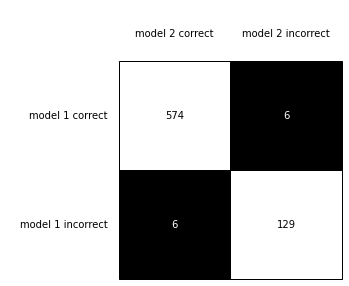


-- WITHOUT SCALING --
- LIWC -
Accuracy:  0.8125874125874126
Precision:  0.7804295942720764
Recall:  0.8861788617886179
F1:  0.8299492385786803

- Empath -
Accuracy:  0.8111888111888111
Precision:  0.7785714285714286
Recall:  0.8861788617886179
F1:  0.8288973384030418

- MCNEMAR TEST -
statistic=0.000, p-value=1.0000
Same proportions of errors (fail to reject H0)


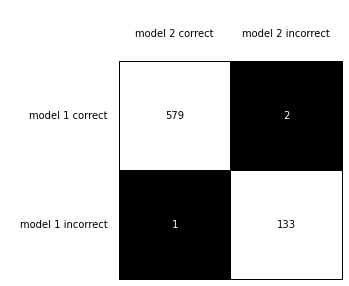

In [7]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000000, random_state=seed))])
print('-- WITH STANDARD SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, pipe)
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, pipe)

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)


print('\n-- WITHOUT SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, LogisticRegression(max_iter=1000000, random_state=seed))
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, LogisticRegression(max_iter=1000000, random_state=seed))

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)

### SVM

-- WITH STANDARD SCALING --
- LIWC -
Accuracy:  0.8097902097902098
Precision:  0.7793764988009593
Recall:  0.8807588075880759
F1:  0.8269720101781172

- Empath -
Accuracy:  0.806993006993007
Precision:  0.7866004962779156
Recall:  0.8590785907859079
F1:  0.8212435233160622

- MCNEMAR TEST -
statistic=0.045, p-value=0.8312
Same proportions of errors (fail to reject H0)


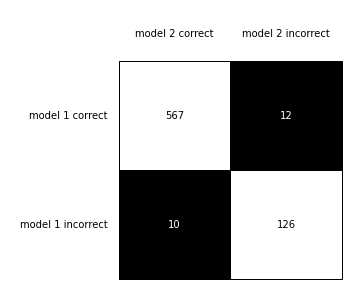


-- WITHOUT SCALING --
- LIWC -
Accuracy:  0.7552447552447552
Precision:  0.7400990099009901
Recall:  0.8102981029810298
F1:  0.7736093143596376

- Empath -
Accuracy:  0.8111888111888111
Precision:  0.7785714285714286
Recall:  0.8861788617886179
F1:  0.8288973384030418

- MCNEMAR TEST -
statistic=10.711, p-value=0.0011
Different proportions of errors (reject H0)


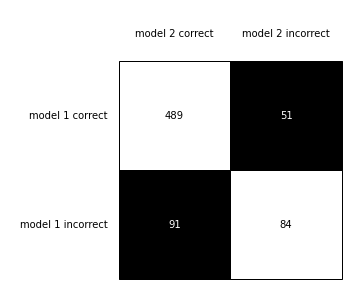

In [8]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVC(random_state=seed))])

print('-- WITH STANDARD SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, pipe)
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, pipe)

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)


print('\n-- WITHOUT SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, SVC(random_state=seed))
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, SVC(random_state=seed))

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)

### Random Forest

-- WITH STANDARD SCALING --
- LIWC -
Accuracy:  0.8083916083916084
Precision:  0.777511961722488
Recall:  0.8807588075880759
F1:  0.8259212198221093

- Empath -
Accuracy:  0.806993006993007
Precision:  0.7756563245823389
Recall:  0.8807588075880759
F1:  0.8248730964467005

- MCNEMAR TEST -
statistic=0.000, p-value=1.0000
Same proportions of errors (fail to reject H0)


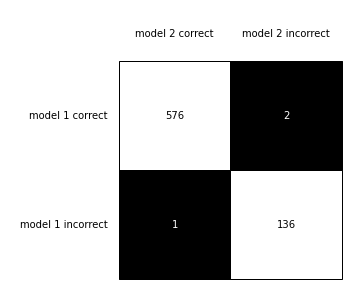


-- WITHOUT SCALING --
- LIWC -
Accuracy:  0.8083916083916084
Precision:  0.777511961722488
Recall:  0.8807588075880759
F1:  0.8259212198221093

- Empath -
Accuracy:  0.806993006993007
Precision:  0.7756563245823389
Recall:  0.8807588075880759
F1:  0.8248730964467005

- MCNEMAR TEST -
statistic=0.000, p-value=1.0000
Same proportions of errors (fail to reject H0)


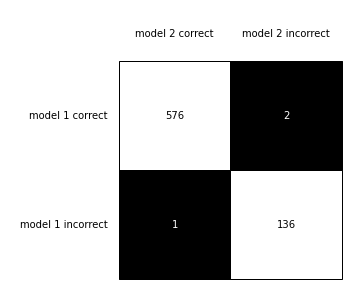

In [9]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf',  RandomForestClassifier(random_state=seed))])

print('-- WITH STANDARD SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, pipe)
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, pipe)

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)


print('\n-- WITHOUT SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, RandomForestClassifier(random_state=seed))
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, RandomForestClassifier(random_state=seed))

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)

## Scraped data

In [10]:
X_train_l, y_train, X_test_l, y_test = prepare_data(dataset_path_train=train_scr, dataset_path_test=test_scr, features=lexic)
X_train_e, y_train, X_test_e, y_test = prepare_data(dataset_path_train=train_scr, dataset_path_test=test_scr, features=basic)

X_train_e = empath(X_train_e)
X_test_e = empath(X_test_e)

X_train_e = X_train_e.drop(columns=to_drop)
X_test_e = X_test_e.drop(columns=to_drop)

### Logistic Regression

-- WITH STANDARD SCALING --
- LIWC -
Accuracy:  0.8195804195804196
Precision:  0.7790697674418605
Recall:  0.907859078590786
F1:  0.8385481852315394

- Empath -
Accuracy:  0.8223776223776224
Precision:  0.7880952380952381
Recall:  0.8970189701897019
F1:  0.8390367553865653

- MCNEMAR TEST -
statistic=0.056, p-value=0.8137
Same proportions of errors (fail to reject H0)


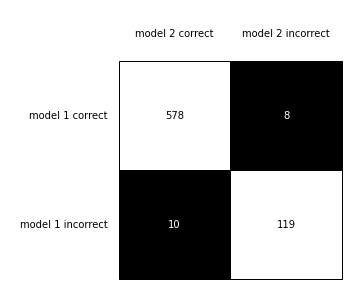


-- WITHOUT SCALING --
- LIWC -
Accuracy:  0.8195804195804196
Precision:  0.7790697674418605
Recall:  0.907859078590786
F1:  0.8385481852315394

- Empath -
Accuracy:  0.8167832167832167
Precision:  0.7741935483870968
Recall:  0.9105691056910569
F1:  0.8368617683686178

- MCNEMAR TEST -
statistic=0.250, p-value=0.6171
Same proportions of errors (fail to reject H0)


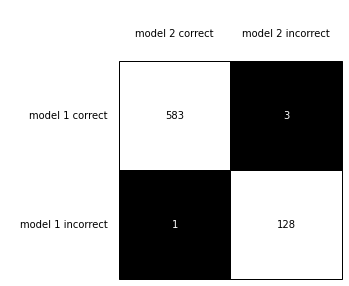

In [11]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000000, random_state=seed))])
print('-- WITH STANDARD SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, pipe)
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, pipe)

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)


print('\n-- WITHOUT SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, LogisticRegression(max_iter=1000000, random_state=seed))
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, LogisticRegression(max_iter=1000000, random_state=seed))

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)

### SVM

-- WITH STANDARD SCALING --
- LIWC -
Accuracy:  0.8153846153846154
Precision:  0.7762237762237763
Recall:  0.9024390243902439
F1:  0.8345864661654137

- Empath -
Accuracy:  0.813986013986014
Precision:  0.7864077669902912
Recall:  0.8780487804878049
F1:  0.8297055057618438

- MCNEMAR TEST -
statistic=0.000, p-value=1.0000
Same proportions of errors (fail to reject H0)


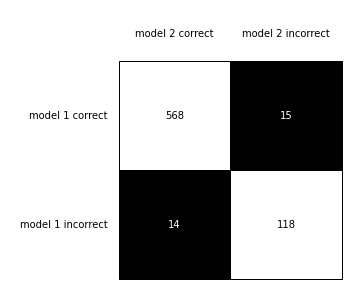


-- WITHOUT SCALING --
- LIWC -
Accuracy:  0.7552447552447552
Precision:  0.7400990099009901
Recall:  0.8102981029810298
F1:  0.7736093143596376

- Empath -
Accuracy:  0.8167832167832167
Precision:  0.7741935483870968
Recall:  0.9105691056910569
F1:  0.8368617683686178

- MCNEMAR TEST -
statistic=12.664, p-value=0.0004
Different proportions of errors (reject H0)


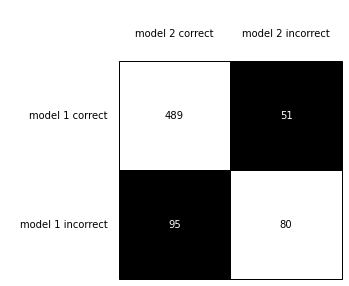

In [12]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVC(random_state=seed))])

print('-- WITH STANDARD SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, pipe)
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, pipe)

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)


print('\n-- WITHOUT SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, SVC(random_state=seed))
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, SVC(random_state=seed))

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)

### Random Forest

-- WITH STANDARD SCALING --
- LIWC -
Accuracy:  0.8111888111888111
Precision:  0.7746478873239436
Recall:  0.8943089430894309
F1:  0.830188679245283

- Empath -
Accuracy:  0.8181818181818182
Precision:  0.7798594847775175
Recall:  0.9024390243902439
F1:  0.8366834170854272

- MCNEMAR TEST -
statistic=1.231, p-value=0.2673
Same proportions of errors (fail to reject H0)


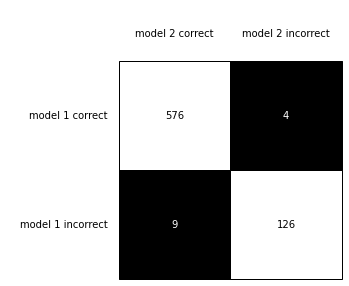


-- WITHOUT SCALING --
- LIWC -
Accuracy:  0.8111888111888111
Precision:  0.7746478873239436
Recall:  0.8943089430894309
F1:  0.830188679245283

- Empath -
Accuracy:  0.8181818181818182
Precision:  0.7798594847775175
Recall:  0.9024390243902439
F1:  0.8366834170854272

- MCNEMAR TEST -
statistic=1.231, p-value=0.2673
Same proportions of errors (fail to reject H0)


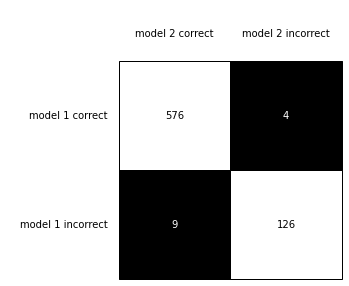

In [13]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf',  RandomForestClassifier(random_state=seed))])

print('-- WITH STANDARD SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, pipe)
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, pipe)

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)


print('\n-- WITHOUT SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, RandomForestClassifier(random_state=seed))
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, RandomForestClassifier(random_state=seed))

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)

## Mental Health Reddit Posts

In [14]:
X_train_l, y_train, X_test_l, y_test = prepare_data(dataset_path_train=train_mh, dataset_path_test=test_mh, features=lexic)
X_train_e, y_train, X_test_e, y_test = prepare_data(dataset_path_train=train_mh, dataset_path_test=test_mh, features=basic)

X_train_e = empath(X_train_e)
X_test_e = empath(X_test_e)

X_train_e = X_train_e.drop(columns=to_drop)
X_test_e = X_test_e.drop(columns=to_drop)

### Logistic Regression

-- WITH STANDARD SCALING --
- LIWC -
Accuracy:  0.8195804195804196
Precision:  0.7777777777777778
Recall:  0.9105691056910569
F1:  0.8389513108614233

- Empath -
Accuracy:  0.8223776223776224
Precision:  0.784037558685446
Recall:  0.9051490514905149
F1:  0.8402515723270441

- MCNEMAR TEST -
statistic=0.045, p-value=0.8312
Same proportions of errors (fail to reject H0)


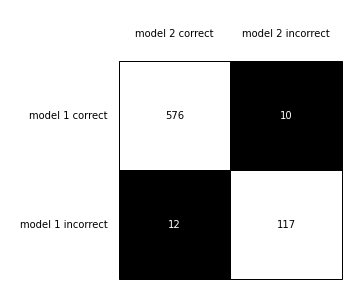


-- WITHOUT SCALING --
- LIWC -
Accuracy:  0.8181818181818182
Precision:  0.777262180974478
Recall:  0.907859078590786
F1:  0.8374999999999999

- Empath -
Accuracy:  0.8181818181818182
Precision:  0.7709750566893424
Recall:  0.9214092140921409
F1:  0.8395061728395061

- MCNEMAR TEST -
statistic=0.100, p-value=0.7518
Same proportions of errors (fail to reject H0)


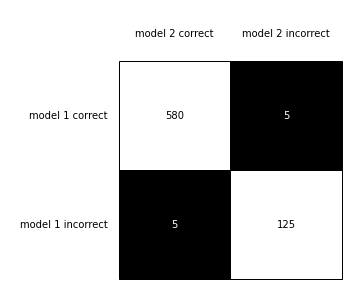

In [15]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000000, random_state=seed))])
print('-- WITH STANDARD SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, pipe)
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, pipe)

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)


print('\n-- WITHOUT SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, LogisticRegression(max_iter=1000000, random_state=seed))
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, LogisticRegression(max_iter=1000000, random_state=seed))

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)

### SVM

-- WITH STANDARD SCALING --
- LIWC -
Accuracy:  0.8181818181818182
Precision:  0.7734553775743707
Recall:  0.9159891598915989
F1:  0.8387096774193549

- Empath -
Accuracy:  0.813986013986014
Precision:  0.7783018867924528
Recall:  0.8943089430894309
F1:  0.832282471626734

- MCNEMAR TEST -
statistic=0.174, p-value=0.6767
Same proportions of errors (fail to reject H0)


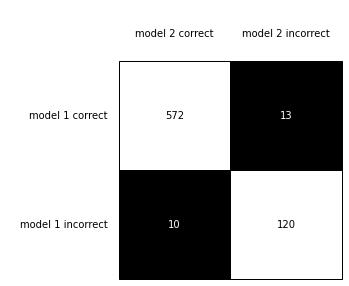


-- WITHOUT SCALING --
- LIWC -
Accuracy:  0.7538461538461538
Precision:  0.7382716049382716
Recall:  0.8102981029810298
F1:  0.7726098191214469

- Empath -
Accuracy:  0.8181818181818182
Precision:  0.7709750566893424
Recall:  0.9214092140921409
F1:  0.8395061728395061

- MCNEMAR TEST -
statistic=13.322, p-value=0.0003
Different proportions of errors (reject H0)


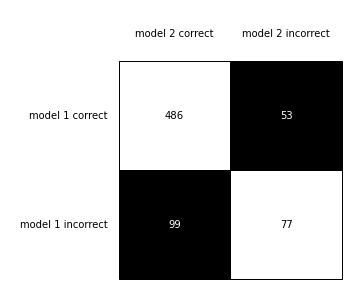

In [16]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVC(random_state=seed))])

print('-- WITH STANDARD SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, pipe)
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, pipe)

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)


print('\n-- WITHOUT SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, SVC(random_state=seed))
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, SVC(random_state=seed))

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)

### Random Forest

-- WITH STANDARD SCALING --
- LIWC -
Accuracy:  0.8083916083916084
Precision:  0.7735849056603774
Recall:  0.8888888888888888
F1:  0.8272383354350568

- Empath -
Accuracy:  0.8167832167832167
Precision:  0.7754629629629629
Recall:  0.907859078590786
F1:  0.8364544319600499

- MCNEMAR TEST -
statistic=1.042, p-value=0.3074
Same proportions of errors (fail to reject H0)


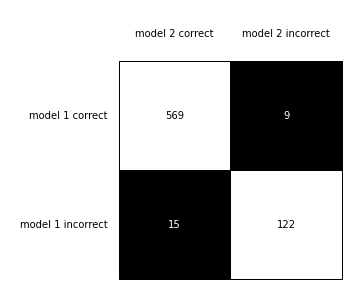


-- WITHOUT SCALING --
- LIWC -
Accuracy:  0.8083916083916084
Precision:  0.7735849056603774
Recall:  0.8888888888888888
F1:  0.8272383354350568

- Empath -
Accuracy:  0.8167832167832167
Precision:  0.7754629629629629
Recall:  0.907859078590786
F1:  0.8364544319600499

- MCNEMAR TEST -
statistic=1.042, p-value=0.3074
Same proportions of errors (fail to reject H0)


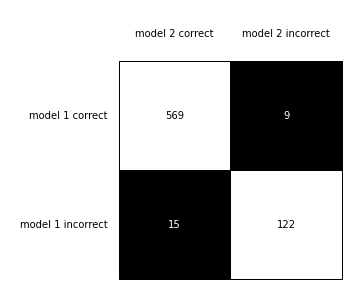

In [17]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf',  RandomForestClassifier(random_state=seed))])

print('-- WITH STANDARD SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, pipe)
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, pipe)

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)


print('\n-- WITHOUT SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, RandomForestClassifier(random_state=seed))
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, RandomForestClassifier(random_state=seed))

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)

## No Roberta Predictions

In [18]:
X_train_l = X_train_l.drop(columns=['roberta_prediction'])
X_test_l = X_test_l.drop(columns=['roberta_prediction'])
X_train_e = X_train_e.drop(columns=['roberta_prediction'])
X_test_e = X_test_e.drop(columns=['roberta_prediction'])

### Logistic Regression

-- WITH STANDARD SCALING --
- LIWC -
Accuracy:  0.7342657342657343
Precision:  0.7220843672456576
Recall:  0.7886178861788617
F1:  0.7538860103626943

- Empath -
Accuracy:  0.6895104895104895
Precision:  0.6939313984168866
Recall:  0.7127371273712737
F1:  0.7032085561497325

- MCNEMAR TEST -
statistic=4.665, p-value=0.0308
Different proportions of errors (reject H0)


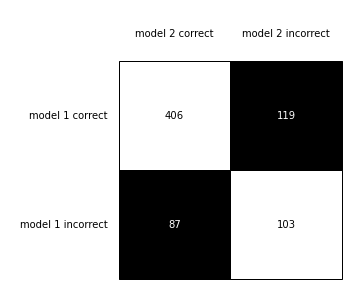


-- WITHOUT SCALING --
- LIWC -
Accuracy:  0.7384615384615385
Precision:  0.7286432160804021
Recall:  0.7859078590785907
F1:  0.7561929595827901

- Empath -
Accuracy:  0.6937062937062937
Precision:  0.6720183486238532
Recall:  0.7940379403794038
F1:  0.7279503105590062

- MCNEMAR TEST -
statistic=5.280, p-value=0.0216
Different proportions of errors (reject H0)


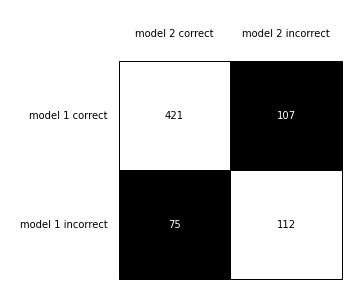

In [19]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000000, random_state=seed))])
print('-- WITH STANDARD SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, pipe)
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, pipe)

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)


print('\n-- WITHOUT SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, LogisticRegression(max_iter=1000000, random_state=seed))
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, LogisticRegression(max_iter=1000000, random_state=seed))

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)

### SVM

-- WITH STANDARD SCALING --
- LIWC -
Accuracy:  0.7608391608391608
Precision:  0.75
Recall:  0.8048780487804879
F1:  0.7764705882352942

- Empath -
Accuracy:  0.6909090909090909
Precision:  0.7032967032967034
Recall:  0.6937669376693767
F1:  0.69849931787176

- MCNEMAR TEST -
statistic=13.192, p-value=0.0003
Different proportions of errors (reject H0)


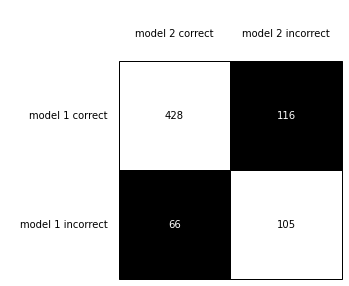


-- WITHOUT SCALING --
- LIWC -
Accuracy:  0.7524475524475525
Precision:  0.7376237623762376
Recall:  0.8075880758807588
F1:  0.7710219922380336

- Empath -
Accuracy:  0.7104895104895105
Precision:  0.7120418848167539
Recall:  0.7371273712737128
F1:  0.7243675099866844

- MCNEMAR TEST -
statistic=4.672, p-value=0.0307
Different proportions of errors (reject H0)


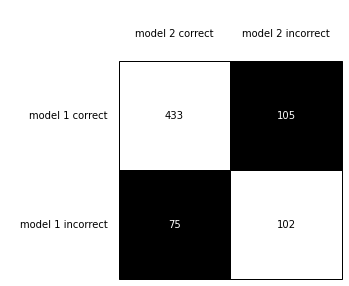

In [20]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVC(random_state=seed))])

print('-- WITH STANDARD SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, pipe)
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, pipe)

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)


print('\n-- WITHOUT SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, SVC(random_state=seed))
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, SVC(random_state=seed))

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)

### Random Forest

-- WITH STANDARD SCALING --
- LIWC -
Accuracy:  0.7538461538461538
Precision:  0.7443037974683544
Recall:  0.7967479674796748
F1:  0.7696335078534031

- Empath -
Accuracy:  0.6937062937062937
Precision:  0.6913265306122449
Recall:  0.7344173441734417
F1:  0.712220762155059

- MCNEMAR TEST -
statistic=9.855, p-value=0.0017
Different proportions of errors (reject H0)


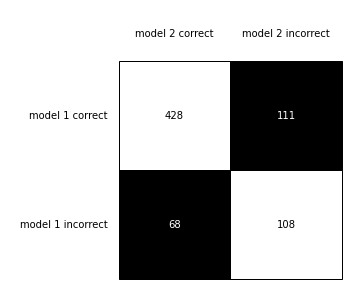


-- WITHOUT SCALING --
- LIWC -
Accuracy:  0.7552447552447552
Precision:  0.7461928934010152
Recall:  0.7967479674796748
F1:  0.7706422018348624

- Empath -
Accuracy:  0.6937062937062937
Precision:  0.6913265306122449
Recall:  0.7344173441734417
F1:  0.712220762155059

- MCNEMAR TEST -
statistic=10.388, p-value=0.0013
Different proportions of errors (reject H0)


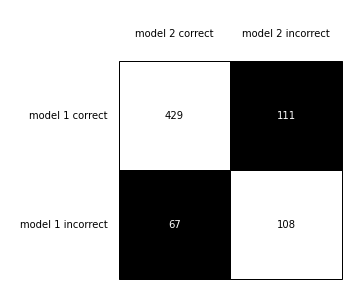

In [21]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf',  RandomForestClassifier(random_state=seed))])

print('-- WITH STANDARD SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, pipe)
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, pipe)

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)


print('\n-- WITHOUT SCALING --')
print('- LIWC -')
y_l = get_predictions(X_train_l, y_train, X_test_l, y_test, RandomForestClassifier(random_state=seed))
print('\n- Empath -')
y_e = get_predictions(X_train_e, y_train, X_test_e, y_test, RandomForestClassifier(random_state=seed))

print('\n- MCNEMAR TEST -')
testsig(y_test, y_l, y_e)

## Conclusion

When used **without Roberta predictions, LIWC features outperform Empath features** at the level of significance 0.05, but **when used in combination with Roberta predictions there are no significant differences in proportion of errors**, what is more, when used without standard scaling, Empath features sometimes outperform LIWC features.